In [4]:
%load_ext cython
%matplotlib notebook


import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import glob
import h5py
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
def magnetization(img):
    return np.sum(img)/np.prod(img.shape)

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
%%cython
cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_energy(np.int64_t[:, :] field):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    cdef int n, m
    cdef float total_E = 0
    cdef float row_E = 0 
    for n in range(N):
        row_E = 0 
        for m in range(M):
            total = 0
            for i in range(n-1, n+2):
                for j in range(m-1, m+2):
                    if i == n and j == m:
                        continue
                    total += field[i % N, j % M]
            row_E += - field[n, m] * total
        total_E += row_E
    return total_E /(N * M)

In [3]:
magnetization_by_temperature = defaultdict(list)
energy_by_temperature = defaultdict(list)
images_by_temperature = defaultdict(list)
for filename in glob.glob('run_*.hdf5'):
    with h5py.File(filename,'r') as input_file:
        beta = input_file.attrs['beta']
        img = np.array(input_file['image'])
        magnet = magnetization(img)
        energy = cy_ising_energy(img)
        magnetization_by_temperature[beta].append(magnet)
        energy_by_temperature[beta].append(energy)
        images_by_temperature[beta].append(img)

In [9]:
def show_data():
    gs = GridSpec(ncols=5, nrows=25)
    betas = magnetization_by_temperature.keys()
    all_energies = []
    all_magnets = []
    all_betas = []
    for b in betas:
        all_energies.extend(energy_by_temperature[b])
        all_magnets.extend(magnetization_by_temperature[b])
        all_betas.extend([float(b)]*10)
    
    fig = plt.figure(figsize = (9, 9))
    img_axes = []
    mag_ax = fig.add_subplot(gs[0:9, :])
    e_ax = fig.add_subplot(gs[11:17, :])
    for i in range(2):
        for j in range(5):
            ax = fig.add_subplot(gs[19 + 3*i : 22 + 3*i, j])
            img_axes.append((i, j, ax))
    
    def show_beta(beta):
        beta = float(beta)
        mag_ax.clear()
        mag_ax.plot(all_betas, all_magnets, 'ok', alpha= 0.3)   
        mag_ax.plot([beta] * 10, magnetization_by_temperature[beta], 'or', alpha= 1.0)
        mag_ax.set_xlabel("beta")
        mag_ax.set_ylabel("Magnetization")
        mag_ax.set_title("beta = {:0.02f}".format(beta))

        e_ax.clear()
        e_ax.plot(all_betas, all_energies, 'ok', alpha= 0.3)
        e_ax.plot([beta] * 10, energy_by_temperature[beta], 'or', alpha= 1.0)

        e_ax.set_xlabel("beta")
        e_ax.set_ylabel("Energy")

        for i, j, ax in img_axes:
            ax.clear()
            ax.imshow(images_by_temperature[beta][5*i + j], 'gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
    
    beta_selector = widgets.SelectionSlider(
        options=['{:0.2f}'.format(b) for b in sorted(set(all_betas))],
        description='beta = ',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        layout=widgets.Layout(width='90%')
    )
    interact(show_beta, beta=beta_selector)

<IPython.core.display.Javascript object>


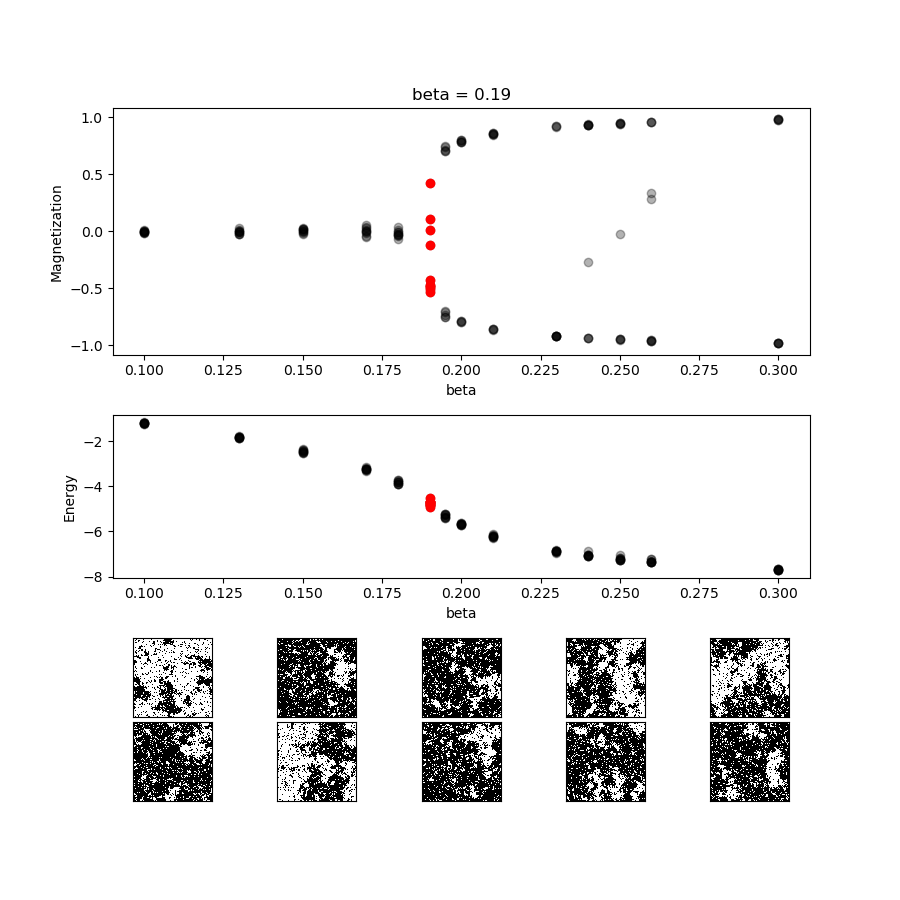

interactive(children=(SelectionSlider(continuous_update=False, description='beta = ', layout=Layout(width='90%…

In [10]:
show_data()